# **Análise Socio-Demográfica**

#### Este notebook tem como objetivo realizar uma análise socioeconômica e demográfica, com foco em um período de 3 meses. O propósito é explorar dados relevantes relacionados a características sociodemográficas da população e suas mudanças ao longo de um período de 3 meses, a ser validado dentro desse notebook.

## A análise visa responder a diversas perguntas, como:

* Como as características demográficas, como idade, gênero, raça/cor, escolaridade e área de domicílio, estão distribuídas na população?
* Existe alguma tendência nas mudanças demográficas ao longo desses 3 meses?
* Qual é a situação do mercado de trabalho e da renda das pessoas dentro deste período?
* Como os sintomas de saúde, como febre, dificuldade respiratória e fadiga, estão relacionados com as características sociodemográficas?
* Há uma relação entre a situação de domicílio e o resultado da COVID-19?
* Por meio dessa análise, pretendemos obter insights que podem ser úteis para tomada de decisão, formulação de políticas públicas e compreensão de tendências sociodemográficas, especialmente em um contexto de pandemia.

# **Preparando o ambiente**

In [90]:
# Criando estrutura para trabalhar dentro dos arquivos do git

!git clone https://github.com/pehls/gp27_techchallenge_3.git

fatal: destination path 'gp27_techchallenge_3' already exists and is not an empty directory.


In [91]:
!pip freeze > ..//requirements.txt

In [92]:
# Instalando google-cloud-bigquery para acessar os dados deste ambiente

!pip install google-cloud-bigquery

In [93]:
# Importe as bibliotecas necessárias
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import numpy as np
import seaborn as sns
import geopandas as gpd

In [94]:
# Inserindo credenciais do projeto no BQ
credentials_path = '/content/gp27_techchallenge_3/credentials_fiap-tech-challenge-3.json'
client = bigquery.Client.from_service_account_json(credentials_path)

# Especificando o projeto e o conjunto de dados que contém a tabela.
project_id = 'fiap-tech-challenge-3'
dataset_id = 'trusted_pnad'
table_id = 'tb_f_covid_2020'

query = f'SELECT * FROM `{project_id}.{dataset_id}.{table_id}`'
query_job = client.query(query)
df = query_job.to_dataframe()

df.head()

,uf,semana_mes,mes,area_domicilio,idade,sexo,cor_raca,escolaridade,teve_febre,teve_dificuldade_respirar,...,teve_fadiga,teve_perda_cheiro,foi_posto_saude,ficou_em_casa,ficou_internado,tem_plano_saude,resultado_covid,assalariado,faixa_rendimento,situacao_domicilio
0,Santa Catarina,1,10,Urbana,76,Masculino,Branca,Médio incompleto,Não,Não,...,Não,Não,NA,NA,NA,Não,Não,NA,NA,Próprio - já pago
1,Santa Catarina,1,10,Urbana,66,Feminino,Branca,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,Não,NA,NA,Próprio - já pago
2,Santa Catarina,1,10,Urbana,54,Feminino,Branca,Médio incompleto,Não,Não,...,Não,Não,NA,NA,NA,Não,Sim,NA,NA,Próprio - já pago
3,Santa Catarina,1,10,Urbana,62,Masculino,Branca,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,Sim,NA,NA,Próprio - já pago
4,Santa Catarina,1,10,Urbana,27,Masculino,Branca,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,Sim,NA,NA,Próprio - já pago


# **Análises iniciais**

## Definição dos 3 meses a serem analisados

#### Para definirmos os meses a serem estudados, primeiro buscamos entender como os dados estão distribuídos por mês durante o ano de 2020 e quantos casos positivos tivemos em cada um deles

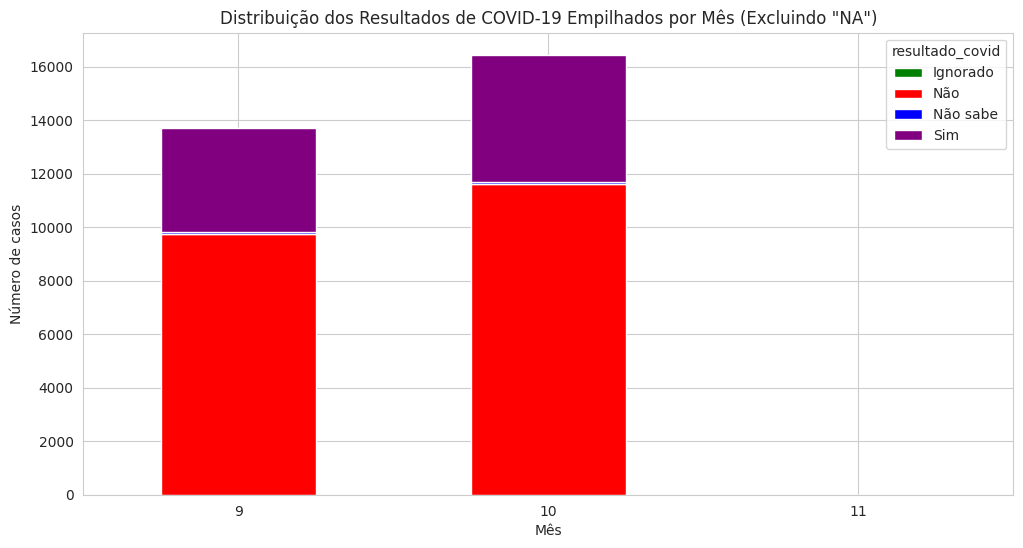

In [95]:
# Criando tabela para verificar apenas pesquisas onde os resultados foram diferentes de 'NA'
df_filtrado = df[df['resultado_covid'] != 'NA']

# Criando uma tabela cruzada para contar os resultados por mês.
crosstab = pd.crosstab(df_filtrado['mes'], df_filtrado['resultado_covid'])

# Criando um gráfico empilhado.
crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), color=['green', 'red', 'blue', 'purple'])

plt.title('Distribuição dos Resultados de COVID-19 Empilhados por Mês (Excluindo "NA")')
plt.xlabel('Mês')
plt.ylabel('Número de casos')
plt.xticks(rotation=0)

plt.show()

#### Com base nos dados acima, é possível identificar que os 3 meses com uma quantidade de registros ccom o valor resultado_covid diferente de NA tem uma amostra mais relevante nos últimos 3 meses da comparação. Nesse caso, optamos por utilizar os meses de novembro(11), outubro(10) e setembro(9).

#### Abaixo vemos como os dados estão segmentados por "categoria" dentro do resultado_covid durante os meses citados

In [96]:
df_filtrado = df[df['resultado_covid'] != 'NA']

meses_selecionados = [9, 10, 11]
df_filtrado = df_filtrado[df_filtrado['mes'].isin(meses_selecionados)]

crosstab = pd.crosstab(df_filtrado['mes'], df_filtrado['resultado_covid'])

percentuais_por_mes = crosstab.apply(lambda row: (row / row.sum()) * 100, axis=1).T
percentuais_por_mes = percentuais_por_mes.round(2)

percentuais_por_mes.head()

mes,9,10,11
resultado_covid,,,
Ignorado,0.01,0.00,0.0
Não,70.89,70.56,100.0
Não sabe,0.64,0.52,0.0
Sim,28.46,28.92,0.0


In [97]:
# Carregue o shapefile
shapefile_path = '/content/gp27_techchallenge_3/estados-brasil'
mapa = gpd.read_file(shapefile_path)

# Liste as informações do shapefile
mapa.head(5)

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,AREA_KM2,geometry
0,12,Acre,AC,Norte,164173.429,"POLYGON ((-68.79282 -10.99957, -68.79367 -10.9..."
1,13,Amazonas,AM,Norte,1559255.881,"POLYGON ((-56.76292 -3.23221, -56.76789 -3.242..."
2,15,Pará,PA,Norte,1245870.704,"MULTIPOLYGON (((-48.97548 -0.19834, -48.97487 ..."
3,16,Amapá,AP,Norte,142470.762,"MULTIPOLYGON (((-51.04561 -0.05088, -51.05422 ..."
4,17,Tocantins,TO,Norte,277423.627,"POLYGON ((-48.24830 -13.19239, -48.24844 -13.1..."


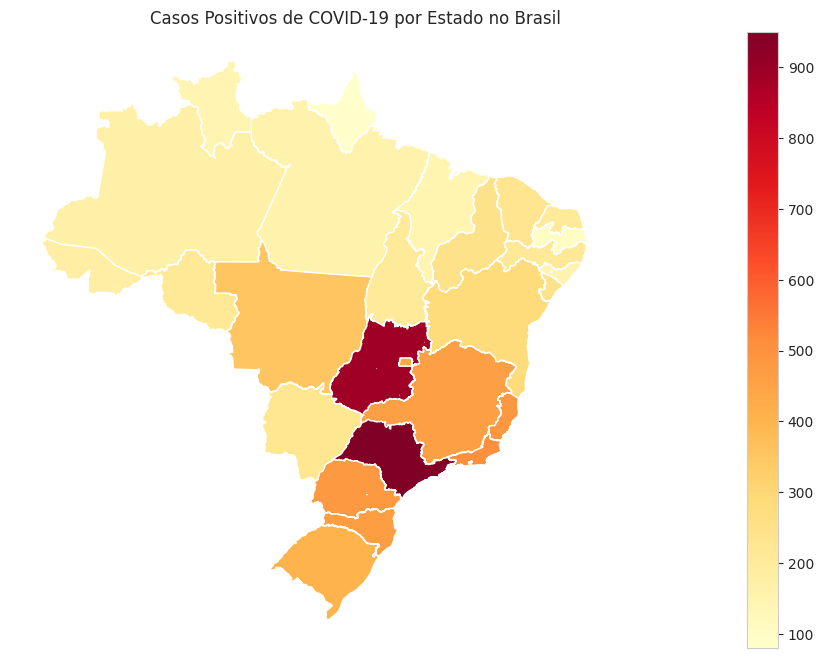

In [98]:
# Filtrar o DataFrame original para casos positivos (resultado_covid igual a 'Sim')
df_casos_positivos = df[df['resultado_covid'] == 'Sim']

# Agregar e contar casos positivos por estado
casos_positivos_por_estado = df_casos_positivos['uf'].value_counts().reset_index()
casos_positivos_por_estado.columns = ['uf', 'Casos Positivos']

# Carregue o shapefile dos estados do Brasil
shapefile_path = '/content/gp27_techchallenge_3/estados-brasil'
mapa = gpd.read_file(shapefile_path)

# Junte o DataFrame `casos_positivos_por_estado` com o mapa usando a sigla dos estados
mapa = mapa.merge(casos_positivos_por_estado, left_on='NM_UF', right_on='uf', how='left')

# Plote o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mapa.plot(column='Casos Positivos', cmap='YlOrRd', ax=ax, legend=True)
ax.set_title('Casos Positivos de COVID-19 por Estado no Brasil')
plt.axis('off')

# Mostre o mapa
plt.show()

# **Análises Socio-demográficas**

#### No gráfico abaixo, poderemos visualizar qual é o percentual de cada "categoria" de cada coluna(feature) da tabela, com base nos resultados de seus exames

#### Obs: Removemos as colunas de mes, semana_mes e idade dessa visualização

In [99]:
# Filtrar o DataFrame para incluir apenas os meses 9, 10 e 11
meses_selecionados = [9, 10, 11]
df_filtrado = df[df['mes'].isin(meses_selecionados)]

# Função para criar um gráfico interativo com percentuais
def criar_grafico(coluna, resultados_selecionados):
    if not resultados_selecionados:
        resultados_selecionados = df['resultado_covid'].unique()

    # Filtrar o DataFrame com base na coluna selecionada e nos resultados escolhidos
    df_filtrado_coluna = df_filtrado[df_filtrado['resultado_covid'].isin(resultados_selecionados) & (df_filtrado[coluna] != 'NA')]

    # Calcular a distribuição em percentuais.
    percentuais = df_filtrado_coluna[coluna].value_counts(normalize=True) * 100

    # Criar um gráfico de barras para mostrar a distribuição dos resultados de COVID-19 pela coluna selecionada.
    plt.figure(figsize=(20, 6))
    resultado_count = df_filtrado_coluna[coluna].value_counts()
    resultado_count.plot(kind='bar', color='skyblue')
    plt.title(f'Distribuição de Resultados positivos de COVID-19 por {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Percentual de casos (%)')
    plt.xticks(rotation=45)

    # Adicionar as porcentagens acima de cada barra.
    for i, valor in enumerate(resultado_count):
        plt.text(i, valor, f'{percentuais[i]:.2f}%', ha='center', va='bottom')

    plt.show()

# Lista de colunas disponíveis para análise (excluindo 'idade' e 'semana_mes')
colunas_disponiveis = [coluna for coluna in df.columns if coluna not in ['idade', 'semana_mes', 'resultado_covid', 'mes']]

# Lista de valores únicos da coluna 'resultado_covid'
valores_resultado_covid = df['resultado_covid'].unique()

# Widget de seleção para escolher a coluna
interact(criar_grafico, coluna=colunas_disponiveis, resultados_selecionados=widgets.SelectMultiple(
    options=valores_resultado_covid,
    value=tuple(valores_resultado_covid),  # Converte para uma tupla
    description='Resultados de COVID',
))

interactive(children=(Dropdown(description='coluna', options=('uf', 'area_domicilio', 'sexo', 'cor_raca', 'esc…

<function __main__.criar_grafico(coluna, resultados_selecionados)>

## Observações sobre as análises socio-demográficas - Resultados Negativos

* Gráficos sobre os **sintomas apresentados**:
  * Mais de 95% da população da pesquisa, em todos os sintomas, não apresentou nenhum dos sintomas estudados. São eles: febre, dificuldade de respirar, dores de cabeça, fadiga ou perda de olfato. O mesmo comportamento é visto entre os pacientes com o resultado covid positivo.

* Gráfico **Cor-raça**:

  * Quase 58% das pessoas que possuem o resultado negativo são da cor-raça Parda.

* Gráfico de **Escolaridade**:

  * 36% dos pacientes que apresentaram o resultado negativo possuem ensino fundamental incompleto.

  * Uma hipótese é que o grau de escolaridade/informação pode ter impacto na percepção desses pacientes sobre os sintomas, e por consequência, podem fazer o teste de maneira "equivocada"

## Observações sobre as análises socio-demográficas - Resultados Positivos

* Gráficos sobre os **sintomas apresentados**:
  * Mais de 95% da população da pesquisa, em todos os sintomas, não apresentou nenhum dos sintomas estudados. São eles: febre, dificuldade de respirar, dores de cabeça, fadiga ou perda de olfato.

* Gráfico sobre **Plano de saúde**:

  * Mais de 55% da população que teve o resultado positivo para a COVID-19 não possuem plano de saúde, isso pode indicar que muito provavelmente dependerão do sistema público de saúde para tratarem de seus resultados e isso pode sobrecarregar o sistema em tempos de pandemia, como foi o caso na época em que a pandemia da COVID-19 estava em seus piores momentos.

  * Além disso, a ausência de plano de saúde também pode estar relacionada aos resultados da COVID-19. Pessoas sem plano de saúde podem ter menos acesso a testes ou tratamento médico, o que pode afetar os resultados e a detecção de casos.

* Gráfico **Cor-raça**:

  * Quase 58% das pessoas que possuem o resultado positivo são da cor-raça Branca. Isso pode indicar que a amostra de dados possui mais registros voltados para as regiões sudeste e sul do Brasil, onde históricamente a população se declara desta cor-raça.
  
  * Outra hipótese que pode embasar este número é que a disponibilidade de testes de COVID-19 e acesso a cuidados de saúde podem variar entre grupos raciais ou étnicos. Isso pode afetar a detecção de casos e a distribuição dos resultados positivos, especialmente nas regiões mais pobres do país.

## **Distribuição Etária - COVID 19**

#### Para a análise com base nos ranges de idade, criaremos faixas de idade para analisar todos os aspectos.

In [100]:
df = query_job.to_dataframe()

# Defina a função para converter idade em faixa etária
def idade_para_faixa_etaria(idade):
    if idade >= 70:
        return "+70"
    faixa_etaria = (idade // 10) * 10
    return f'{faixa_etaria}-{faixa_etaria + 9} anos'

# Aplique a função à coluna 'idade' e substitua os valores na própria coluna
df['idade'] = df['idade'].apply(idade_para_faixa_etaria)

df.head()

,uf,semana_mes,mes,area_domicilio,idade,sexo,cor_raca,escolaridade,teve_febre,teve_dificuldade_respirar,...,teve_fadiga,teve_perda_cheiro,foi_posto_saude,ficou_em_casa,ficou_internado,tem_plano_saude,resultado_covid,assalariado,faixa_rendimento,situacao_domicilio
0,Santa Catarina,1,10,Urbana,+70,Masculino,Branca,Médio incompleto,Não,Não,...,Não,Não,NA,NA,NA,Não,Não,NA,NA,Próprio - já pago
1,Santa Catarina,1,10,Urbana,60-69 anos,Feminino,Branca,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,Não,NA,NA,Próprio - já pago
2,Santa Catarina,1,10,Urbana,50-59 anos,Feminino,Branca,Médio incompleto,Não,Não,...,Não,Não,NA,NA,NA,Não,Sim,NA,NA,Próprio - já pago
3,Santa Catarina,1,10,Urbana,60-69 anos,Masculino,Branca,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,Sim,NA,NA,Próprio - já pago
4,Santa Catarina,1,10,Urbana,20-29 anos,Masculino,Branca,Médio completo,Não,Não,...,Não,Não,NA,NA,NA,Não,Sim,NA,NA,Próprio - já pago


<ipython-input-101-f688cf77e219>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(ordem_faixas_etarias)


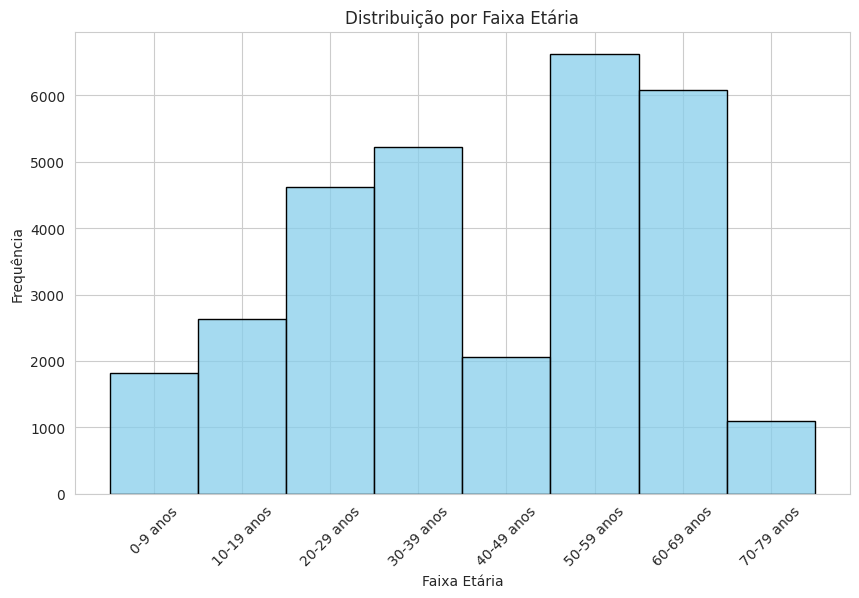

In [101]:
# Defina a ordem das faixas etárias
ordem_faixas_etarias = ['0-9 anos', '10-19 anos', '20-29 anos', '30-39 anos', '40-49 anos', '50-59 anos', '60-69 anos', '70-79 anos', '80-89 anos', '90-99 anos', '100-109 anos', '110-119 anos']

# Crie o histograma ordenado com Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='idade', bins=len(ordem_faixas_etarias), kde=False, color='skyblue', edgecolor='black', discrete=True)
plt.xlabel('Faixa Etária')
plt.ylabel('Frequência')
plt.title('Distribuição por Faixa Etária')
plt.xticks(rotation=45)
plt.gca().set_xticklabels(ordem_faixas_etarias)
plt.show()

In [102]:
# Filtrar o DataFrame para incluir apenas os meses 9, 10 e 11
meses_selecionados = [9, 10, 11]
df_filtrado = df[df['mes'].isin(meses_selecionados)]

# Função para criar um gráfico interativo com percentuais
def criar_grafico(coluna, resultados_selecionados):
    if not resultados_selecionados:
        resultados_selecionados = df['idade'].unique()

    # Filtrar o DataFrame com base na coluna selecionada e nos resultados escolhidos
    df_filtrado_coluna = df_filtrado[df_filtrado['idade'].isin(resultados_selecionados) & (df_filtrado[coluna] != 'NA')]

    # Calcular a distribuição em percentuais.
    percentuais = df_filtrado_coluna[coluna].value_counts(normalize=True) * 100

    # Criar um gráfico de barras para mostrar a distribuição dos resultados de COVID-19 pela coluna selecionada.
    plt.figure(figsize=(20, 6))
    resultado_count = df_filtrado_coluna[coluna].value_counts()
    resultado_count.plot(kind='bar', color='skyblue')
    plt.title(f'Distribuição de Resultados positivos de COVID-19 por {coluna}')
    plt.xlabel(coluna)
    plt.ylabel('Percentual de casos (%)')
    plt.xticks(rotation=45)

    # Adicionar as porcentagens acima de cada barra.
    for i, valor in enumerate(resultado_count):
        plt.text(i, valor, f'{percentuais[i]:.2f}%', ha='center', va='bottom')

    plt.show()

# Lista de colunas disponíveis para análise (excluindo 'idade' e 'semana_mes')
colunas_disponiveis = [coluna for coluna in df.columns if coluna not in ['semana_mes', 'resultado_covid', 'mes']]

# Separe os valores "+70" dos outros valores de idade
valores_idade = df['idade'].unique()
valores_idade = [idade for idade in valores_idade if idade != "+70"]
valores_idade = sorted(valores_idade) + ["+70"]

# Widget de seleção para escolher a coluna
interact(criar_grafico, coluna=colunas_disponiveis, resultados_selecionados=widgets.SelectMultiple(
    options=valores_idade,
    value=tuple(valores_idade),  # Converte para uma tupla
    description='Idades',
))

interactive(children=(Dropdown(description='coluna', options=('uf', 'area_domicilio', 'idade', 'sexo', 'cor_ra…

<function __main__.criar_grafico(coluna, resultados_selecionados)>